In [12]:
import numpy as np

class Polynom:
    """Class for Polynoms.
    For simplicity here: deg(P=0) = deg(P=a, a≠0) = 0
    """
    def __init__(self, arg):
        if isinstance(arg, int):
            assert arg >= 0, f"Expected non-negative degree, got {arg}."
            self.deg = arg
            self.coeffs = np.zeros(arg + 1)
        elif isinstance(arg, np.ndarray):
            assert arg.ndim == 1, "Coefficients must be a 1D array."
            self.coeffs = arg.astype(float)
            self.deg = len(self.coeffs) - 1
        else:
            raise TypeError("Polynom constructor expects an int or a 1D numpy array.")

    def __call__(self, x: float):
        result = 0.0
        power = 1.0
        for c in self.coeffs:
            result += c * power
            power *= x
        return result

    def __str__(self):
        return f"<Polynom deg={self.deg}, coeffs={self.coeffs}>"

    def set_coeff(self, id_coeff:int, coeff:float):
        assert id_coeff<=self.deg and id_coeff>=0, ValueError(
            f"Expected a coefficient the polynom has, got {id_coeff}.")
        self.coeffs[id_coeff] = coeff
    
    def get_coeff(self, id_coeff:int):
        assert id_coeff<=self.deg and id_coeff>=0, ValueError(
            f"Expected a coefficient the polynom has, got {id_coeff}.")
        return self.coeffs[id_coeff]

    def set_deg(self, deg:int):
        assert deg>=0, ValueError(
            f"Expected a positive polynom degree, got {deg}.")
        if deg < self.deg:
            self.coeffs = self.coeffs[: deg]
        else:
            self.coeffs = np.append(self.coeffs, np.zeros(deg - self.deg))
        self.deg = deg
    
    def get_deg(self):
        return self.deg

    def derive(self):
        if self.deg == 0:
            self.coeffs = np.array([0.0])
        else:
            deriv = np.empty(self.deg)
            for i in range(1, self.deg+1):
                deriv[i - 1] = i * self.coeffs[i]

            self.deg -= 1
            self.coeffs = deriv
    
    def add(self, p: np.ndarray):
        n = max(self.deg, p.get_deg())
        res = np.zeros(n+1)
        for i in range(self.deg + 1):
            res[i] += self.coeffs[i]
        for i in range(p.get_deg() + 1):
            res[i] += p.coeffs[i]

        last_non_zero = 0
        for i in reversed(range(n + 1)):
            if abs(res[i]) > 1e-14:
                last_non_zero = i
                break
        
        self.deg = last_non_zero
        self.coeffs = res[:last_non_zero + 1]

    def mul_scalar(self, scalar: float):
        self.coeffs *= scalar
        if scalar == 0:
            self.deg = 0

    def mul_X(self):
        res = np.zeros(self.deg + 2)
        for i in range(self.deg + 1):
            res[i + 1] = self.coeffs[i]

        self.deg += 1
        self.coeffs = res

    def copy(self):
        p = Polynom(self.deg)
        p.coeffs = np.copy(self.coeffs)
        return p

class AssociatedLegendrePolynomsCalculator:
    """Class for associated Legendre Polynoms for m=2 (used for gravitationnal weak lensing).
    """
    def __init__(self):
        self.P2 = Polynom(np.array([3, 0, -3]))
        self.P3 = Polynom(np.array([0, 15, 0, -15]))
        self.polynoms = [self.P2, self.P3]
    
    def __str__(self):
        return f"<AssociatedLegendrePolynoms n={len(self.polynoms)}>"
    
    def __call__(self, nb_l:int):
        assert nb_l>=0, ValueError(
            f"Expected l>=0, got {nb_l}.")

        if nb_l<=2:
            return self.polynoms[:l]
        
        P0 = self.P2.copy()
        P1 = self.P3.copy()
        for l in range(3, nb_l+1):
            P_next = self.next_assoc_legendre(l, 2, P0, P1)
            P0, P1 = P1, P_next
            self.polynoms.append(P_next)
        return self.polynoms

    @staticmethod
    def next_assoc_legendre(l:int, m:int, P0:Polynom, P1:Polynom):
        P = Polynom(P1.get_deg()+1)

        a = P1.copy()
        b = P0.copy()

        a.mul_scalar((2*l + 1) / (l - m + 1))
        a.mul_X()

        b.mul_scalar(-(l + m) / (l - m + 1))

        P.add(a)
        P.add(b)
        return P


### $\xi^{(i,j)}_\theta$ definition

In [39]:
###
from numba import njit

def _inv_H_LCDM(z, H0, omega_m):
    return 1.0 / _H_LCDM(z, H0, omega_m)

def integral_trapezoid(func, a, b, N, **kwargs):
    h = (b - a) / N
    result = 0.5 * (func(a, **kwargs) + func(b, **kwargs))
    for i in range(1, N):
        result += func(a + i * h, **kwargs)
    result *= h
    return result

def _H_LCDM(z, H0, Omega_m_0):
    return H0 * np.sqrt(Omega_m_0 * (1 + z)**3 + (1 - Omega_m_0))

def get_chi(z, H0, omega_m, c):
    return c * integral_trapezoid(_inv_H_LCDM, 0.0, z, 100, H0=H0, omega_m=omega_m)

def get_z(chi_val, chi_vals, z_vals):
    i_chi = np.argmin(np.abs(chi_vals-chi_val))
    return z_vals[i_chi]

## not njit
def get_n(i, z):
    i_nearest = np.argmin(np.abs(z_vals - z))
    return nz_des[f'BIN{i_bin}'][i_nearest]

# def integrand_w(chi_val_integrand, chi_val_W, chi_vals, z_vals, i, H0, omega_m, c):
#     z_chi_integrand = get_z(chi_val_integrand, chi_vals, z_vals)
#     dz_dchi_integrand = _H_LCDM(z_chi_integrand, H0, omega_m) / c
#     n_i_z = get_n(i=i, z=z_chi_integrand)
#     return n_i_z * dz_dchi_integrand * (chi_val_integrand - chi_val_W) / chi_val_integrand

# def w(i, chi_val, z_chi_val, chi_vals, z_vals, chi_H, H0, omega_m, c):
#     integral = integral_trapezoid(integrand_w, chi_val, chi_H, 100, chi_val_W=chi_val, chi_vals=chi_vals, z_vals=z_vals, i=i, H0=H0, omega_m=omega_m, c=c)
#     return 1.5 * omega_m * (H0/c)**2 * chi_val * (1+z_chi) * integral

def integrand_w(chi_prime, chi_W, z_grid, H0, Omega_m_0, i_bin, nz_des):
    z_prime = z_of_chi(chi_prime, z_grid, H0, Omega_m_0) # z(chi')
    dz_dchi = _H_LCDM(z_prime, H0, Omega_m_0) / c
    n_i = get_n(i_bin, z_prime, z_grid, nz_des)
    return n_i * dz_dchi * (chi_prime - chi_W) / chi_prime

def w_i(i_bin, chi_W, z_grid, chi_H, H0, Omega_m_0, nz_des):
    z_W = z_of_chi(chi_W, z_grid, H0, Omega_m_0)
    prefac = 1.5 * Omega_m_0 * (H0 / c)**2 * chi_W * (1.0 + z_W)
    integ = integral_trapezoid(
        integrand_w, chi_W + 1e-6, chi_H, 400,
        chi_W=chi_W, z_grid=z_grid, H0=H0, Omega_m_0=Omega_m_0, i_bin=i_bin, nz_des=nz_des
    )
    return prefac * integ

### Intégrer P

def integrand_ClEE(chi_val, i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals):
    z_chi_val = get_z(chi_val=chi_val, chi_vals=chi_vals, z_vals=z_vals)
    P_cal = P(k=(l+0.5)/chi_val, z=z_chi_val, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact)
    return w(i, chi_val, z_chi_val, chi_vals, z_vals, chi_H, H0, omega_m, c) * w(j, chi_val, chi_vals, z_vals, chi_H, H0, omega_m, c) / (chi_val**2) * P_cal

def ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals):
    return integral_trapezoid(integrand_ClEE, 1e-6, chi_H, 100, i=i, j=j, l=l, H0=H0, omega_m=omega_m, Omega_m=Omega_m, Omega_b=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact, chi_H=chi_H, chi_vals=chi_vals, z_vals=z_vals)

def ClBB(i, j, l):
    return 0.0

def Gp(x, l, aL_pols):
    return - ( (l-4) / (1-x**2) + 0.5 * l * (l-1) ) * aL_pols[l](x) + (l+2) * (x / (1-x**2)) * aL_pols[l-1](x)

def Gm(x, l, aL_pols):
    return 2 * ( (l-1) * x / (1-x**2) * aL_pols[l](x) - (l+2) * (1 / (1-x**2)) * aL_pols[l-1](x))

def xip(theta, i, j, aL_pols, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, nb_l):
    xi = 0.0
    for l in range(2, nb_l):
        xi += (2*l + 1)/(2*np.pi * l**2 * (l+1)**2) * (Gp(np.cos(theta), l, aL_pols) + Gm(np.cos(theta), l, aL_pols)) * (ClEE(i, j, l, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals) + ClBB(i, j, l))
    return xi

def chi2_wl(xip_data, xip_angle, bin1, bin2, nb_l, aL_pols, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals):
    delta_xi = np.empty(len(xip_data))
    omega_m = Omega_m * h**2
    for i in range(len(xip_data)):
        delta_xi[i] = xip_data[i] - xip(xip_angle[i], bin1[i], bin2[i], aL_pols, H0, omega_m, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, nb_l)
    return delta_xi @ np.linalg.inv(desy3_covmat) @ delta_xi

In [40]:
from astropy.io import fits

file_path = 'DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits'

with fits.open(file_path) as hdul:
    hdul.info()
    xip_data = hdul['xip'].data
    xim_data = hdul['xim'].data
    desy3_covmat = hdul['COVMAT'].data
    nz_data_des = hdul['nz_source_des'].data
    nz_source_kids = hdul['nz_source_kids'].data

z_vals_des = nz_data_des['Z_MID']
z_vals_kids = nz_source_kids['Z_MID']
n_bin1 = nz_data_des['BIN1']

xi_minus_data = xim_data['VALUE']
xi_minus_ang = xim_data['ANG']
xi_plus_data = xip_data['VALUE']
xi_plus_ang = xip_data['ANG']

nb_l = 10

H0 = 73.4
h = 0.674
c = 299792.458
Omega_m = 0.315
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
n_s = 2.1e-9
n_s = 0.965
k_star = 0.05

chi_H = 0.5 ## valeur fausse

N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

z_vals = np.linspace(0, 10, 1000)
chi_vals = get_chi(z=z_vals, H0=H0, omega_m=Omega_m * h**2, c=c)

chi2_wl(xip_data=xi_plus_data,
        xip_angle=xi_plus_ang,
        bin1=nz_data_des['BIN1'],
        bin2=nz_data_des['BIN2'],
        nb_l=nb_l,
        aL_pols = AssociatedLegendrePolynomsCalculator()(nb_l=nb_l),
        H0=H0,
        Omega_m=Omega_m,
        Omega_b=Omega_b,
        Omega_gamma=Omega_gamma,
        h=h,
        c=c,
        n_s=n_s,
        k_star=k_star,
        A_s=A_s,
        fact=fact,
        chi_H=chi_H,
        chi_vals=chi_vals,
        z_vals=z_vals)

Filename: DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  nz_source_kids    1 BinTableHDU     53   119R x 8C   [D, D, D, D, D, D, D, D]   
  2  nz_source_des    1 BinTableHDU     47   300R x 7C   [D, D, D, D, D, D, D]   
  3  En            1 BinTableHDU     29   75R x 5C   [D, D, D, D, D]   
  4  xip           1 BinTableHDU     54   200R x 8C   [K, K, K, D, D, D, D, D]   
  5  xim           1 BinTableHDU     54   200R x 8C   [K, K, K, D, D, D, D, D]   
  6  COVMAT        1 ImageHDU        14   (475, 475)   float64   


KeyError: "Key 'BIN1.3350632414186527e-05' does not exist."

### $P(k,z)$ definition

In [35]:
from classy import Class
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

### FUNCTIONS

@njit
def _omega_m(z, Omega_m_0):
    return Omega_m_0 * (1 + z)**3 / (Omega_m_0 * (1 + z)**3 + 1 - Omega_m_0)

@njit
def _g(z, Omega_m_0, Omega_L_0=0.7):
    omz = _omega_m(z, Omega_m_0)
    olz = 1 - omz
    return 2.5 * omz / (omz**(4/7) - olz + (1 + omz/2) * (1 + olz/70))

@njit
def _D(z, Omega_m_0, Omega_L_0=0.7):
    return _g(z, Omega_m_0, Omega_L_0) / _g(0, Omega_m_0, Omega_L_0) / (1 + np.asarray(z))

@njit
def z_d(Omega_m_0, Omega_b_0, h):
    """Drag epoch redshift

    Args:
        Omega_m_0 (float)
        Omega_b_0 (float)
        h (float)

    Returns:
        float: z_d
    """
    omega_m_0 = Omega_m_0 * h**2
    omega_b_0 = Omega_b_0 * h**2

    b1 = 0.313 * omega_m_0**(-0.419) * (1 + 0.607 * omega_m_0**0.674)
    b2 = 0.238 * omega_m_0**0.223

    return (1291 * omega_m_0**0.251) / (1 + 0.659 * omega_m_0**0.828) * (1 + b1 * omega_b_0**b2)

@njit
def s(Omega_m_0, Omega_b_0, Omega_gamma, h):
    """Sound scale (Mpc) (Eisenstein & Hu 1998 Eq. 6)
    Args:
        Omega_m_0 (float)
        Omega_b_0 (float)
        Omega_gamma (float)
        h (float)
    """
    def integrand_s(z):
        R = 0.75 * Omega_b_0 / Omega_gamma / (1 + z)
        Hz = _H_LCDM(z, H0=100*h, Omega_m_0=Omega_m_0)
        return c / np.sqrt(3 * (1 + R)) / Hz
    
    z_d_value = z_d(Omega_m_0, Omega_b_0, h)
    z_max = 1e5
    return integral_trapezoid(func=integrand_s, a=z_d_value, b=z_max, N=100)

@njit  
def s2(omega_m_0, f_baryon):
    """Sound scale approximation (Mpc)

    Args:
        omega_m_0 (float)
        f_baryon (float): omega_b_0/omega_m_0

    Returns:
        float: s
    """
    return 44.5 * np.log(9.83/omega_m_0) / np.sqrt(1 + 10.0 * (omega_m_0*f_baryon)**0.75)

@njit
def alpha_gamma(omega_m_0, omega_b_0):
    """α_Γ coefficient (Eisenstein & Hu 1998 Eq. 31)

    Args:
        omega_m_0 (float)
        omega_b_0 (float)

    Returns:
        float: α_Γ
    """
    return 1 - 0.328 * np.log(431 * omega_m_0) * (omega_b_0 / omega_m_0) + 0.38 * np.log(22.3 * omega_m_0) * (omega_b_0 / omega_m_0)**2

@njit
def Gamma_eff(k, Omega_m_0, Omega_b_0, Omega_gamma, h):
    """Γ_eff oefficient (Eisenstein & Hu 1998 Eq. 30)

    Args:
        k (float)
        Omega_m_0 (float)
        Omega_b_0 (float)
        Omega_gamma (float)
        h (float)

    Returns:
        float: Γ_eff
    """
    alpha_gamma_val = alpha_gamma(Omega_m_0, Omega_b_0, h)
    s_val = s(Omega_m_0, Omega_b_0, Omega_gamma, h)
    return Omega_m_0 * h * (alpha_gamma_val + (1 - alpha_gamma_val) / (1 + (0.43 * k * s_val)**4))

@njit
def q(k, Omega_m_0, Omega_b_0, Omega_gamma, h):
    """q coefficient (Eisenstein & Hu 1998 Eq. 28)

    Args:
        k (float)
        Omega_m_0 (float)
        Omega_b_0 (float)
        Omega_gamma (float)
        h (float)

    Returns:
        float: q
    """
    Gamma_eff_val = Gamma_eff(k, Omega_m_0, Omega_b_0, Omega_gamma, h)
    return k / Gamma_eff_val

@njit
def T_k(k, Omega_m_0, Omega_b_0, Omega_gamma, h):
    """T(k)

    Args:
        k (float)
        Omega_m_0 (float)
        Omega_b_0 (float)
        Omega_gamma (float)
        h (float)

    Returns:
        float: T(k)
    """
    omega_m_0 = Omega_m_0 * h**2
    f_baryon = Omega_b_0/Omega_m_0
    k_equality = 0.0746 * omega_m_0
    q = k / 13.41 / k_equality
    alpha_gamma_val = alpha_gamma(omega_m_0, Omega_b_0*h**2)
    q_eff = q / (alpha_gamma_val + (1-alpha_gamma_val) / (1 + (0.43*k * s2(omega_m_0, f_baryon))**4))
    T_nowiggles_L0 = np.log(2.0*np.e + 1.8*q_eff)
    T_nowiggles_C0 = 14.2 + 731.0 / (1 + 62.5 * q_eff)
    return T_nowiggles_L0 / ( T_nowiggles_L0 + T_nowiggles_C0 * q_eff**2 )

@njit
def P_k_z(k, A_s, k_star, n_s, Tdm):
    """P(k, z)

    Args:
        k (float)
        A_s (float)
        k_star (float)
        n_s (float)
        Tdm (float)

    Returns:
        float: P(k, z)
    """
    P_R = (2*np.pi**2 / k_grid**3) * A_s * (k_grid/k_pivot)**(n_s - 1)
    return P_R * Tdm**2

@njit
def T_k_z(k, z, Omega_m_0, Omega_b_0,Omega_gamma, h, c, fact):
    """T(k, z)

    Args:
        k (float)
        z (float)
        Omega_m_0 (float)
        Omega_b_0 (float)
        Omega_gamma (float)
        h (float)
        c (float)
        fact (float): _description_

    Returns:
        float: T(k, z)
    """
    return fact * 2/5 * k**2 / ((100 * h / c)**2 * Omega_m_0) * T_k(k, Omega_m_0, Omega_b_0, Omega_gamma, h) * _D(z, Omega_m_0)

@njit
def P(k, z, Omega_m_0, Omega_b_0, Omega_gamma, h, c, n_s, k_star, A_s, fact):
    T = T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m_0, Omega_b_0=Omega_b_0, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    return P_k_z(k=k_grid, A_s=A_s, k_star=k_star, n_s=n_s, Tdm=T)

## Comparison plots

1.085083259549129 1.0854929446003678 1.0851547916152606
-1.0039920763292391 -0.941865954665012 -0.9645675520018693
0.9729290154971255
0.9625927390617043 1.093767234073548 1.009905841473989


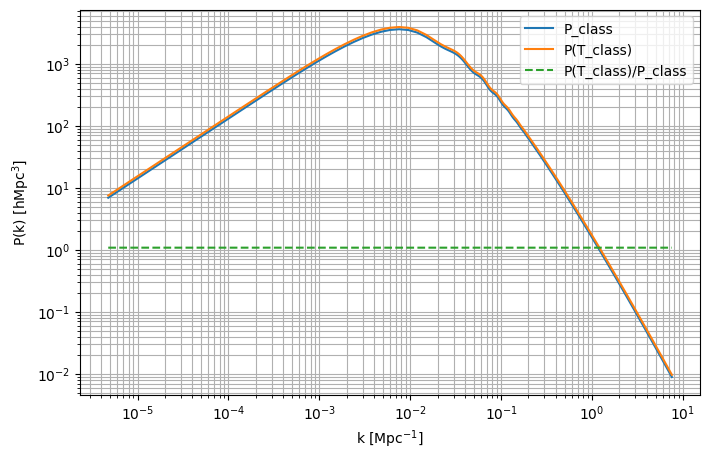

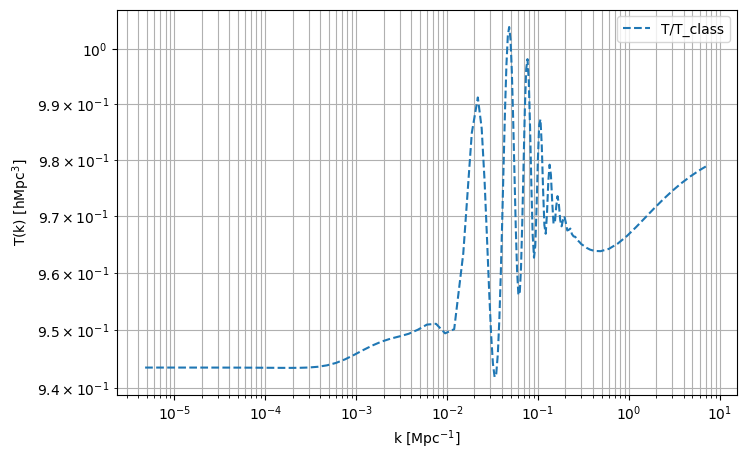

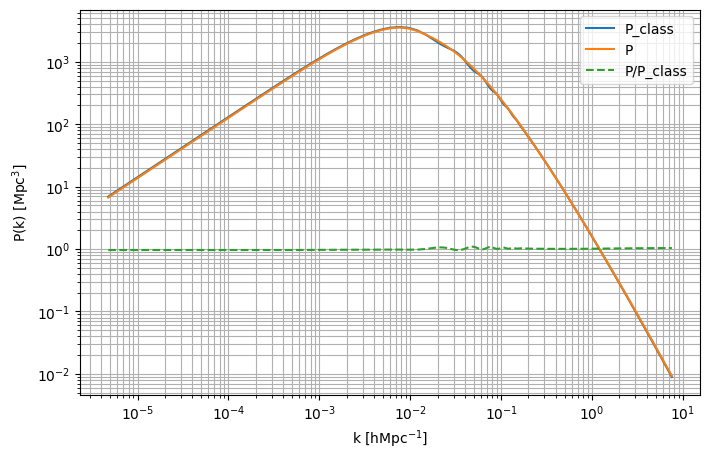

In [8]:
### PARAMETERS

c = 299792.458
h = 0.674
Omega_m = 0.315
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
A_s = 2.1e-9
n_s = 0.965
k_pivot = 0.05   # 1/Mpc
z = 5 # entre 0 et 6 pour KiDS (0 et 3 pour DESy3)
N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

### CLASS
cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'dTk,mPk',
    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0
})
cosmo.compute()

transfer, k_grid, z_grid = cosmo.get_transfer_and_k_and_z()

compare = {
    'T-T_class': True,
    'P(T_class)-P_class': True,
    'P-P_class': True
}

iz = np.argmin(np.abs(z_grid - z))

if compare['P(T_class)-P_class']:
    plt.figure(figsize=(8,5))
    P_cal = P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=transfer['d_m'][:, iz])
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P(T_class)')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P(T_class)/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('P(k) [hMpc$^3$]')
    plt.legend();
if compare['T-T_class']:
    plt.figure(figsize=(8,5))
    T = T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    T_class = transfer['d_m'][:, iz]
    ratio = T / T_class
    print(ratio.min(), ratio.max(), ratio.mean())
    print(0.5*(np.abs(ratio).min()+np.abs(ratio).max()))
    # plt.loglog(h*k_grid, -T_class, label='T_class')
    # plt.loglog(h*k_grid, T, label='T')
    plt.loglog(h*k_grid, -T/T_class, '--', label='T/T_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('T(k) [hMpc$^3$]')
    plt.legend();
if compare['P-P_class']:
    plt.figure(figsize=(8,5))
    # T = T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    # P = P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_cal = P(k_grid, z, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_pivot, A_s, fact)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [hMpc$^{-1}$]')
    plt.ylabel('P(k) [Mpc$^3$]')
    plt.legend();

/tmp/ipykernel_7940/2097025534.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")


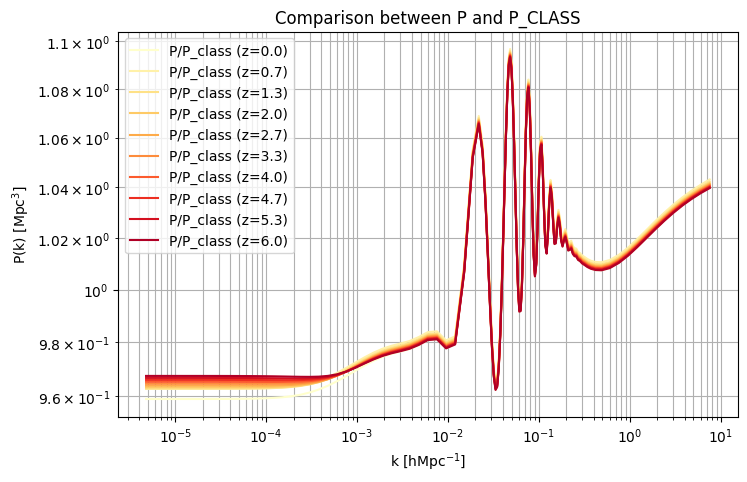

In [9]:
from matplotlib import cm  # colormaps
from matplotlib.colors import Normalize

cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'mPk',

    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0,
})
cosmo.compute()

k_vals = np.logspace(-3, 1, 124)

# Tracer
plt.figure(figsize=(8,5))
Nz = 10
z_array = np.linspace(0,6,Nz)

norm = Normalize(vmin=0, vmax=Nz)
cmap = cm.get_cmap("YlOrRd")
for i in range(len(z_array)):
    z = z_array[i]
    T = T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    P = P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P / P_class
    plt.loglog(h*k_grid, P/P_class, color=cmap(norm(i)), label=f'P/P_class (z={z:.1f})')

plt.legend(); plt.xlabel('k [hMpc$^{-1}$]'); plt.ylabel('P(k) [Mpc$^3$]')
plt.title(f'Comparison between P and P_CLASS')
plt.grid(True, which='both')
plt.show()
